# Double Descent with 1 Hidden Layer Neural Networks 

In this notebook, we identify the double descent phenomenon when training 1 hidden layer neural networks.  Again, given a dataset $\{(x^{(i)}, y^{(i)})\}_{i=1}^{n} \subset \mathbb{R}^{d} \times \mathbb{R}$, we wish to learn a map from $x^{(i)} \to y^{(i)}$.  To learn such a map, we use the following 1 hidden layer nonlinear network: 
\begin{align*}
    f(\mathbf{W} ; x) = a \frac{\sqrt{c}}{\sqrt{k}} \phi(B x) ~~;
\end{align*}
where $a \in \mathbb{R}^{1 \times k}$, $B \in \mathbb{R}^{k \times d}$, $x \in \mathbb{R}^{d}$, $c \in \mathbb{R}$ is a fixed constant, $\phi$ is an elementwise nonlinearity, and $\mathbf{W}$ is a vectorized version of all entries of $a, B$ (e.g. $\mathbf{W} \in \mathbb{R}^{k + dk}$).  We will also assume that $\phi$ is a real valued function (as is the case in many models in practice).  


We will assume that the parameters $\mathbf{W}_i \overset{i.i.d}{\sim} \mathcal{N}(0, 1)$.  We then use gradient descent to minimize the following loss: 
\begin{align}
    \mathcal{L}(w) = \sum_{i=1}^{n} ( y^{(i)} - f(x^{(i)}))^2  ~~;
\end{align}

We will now show that double descent occurs when the number of hidden units $k$ increases.  

**Note:** The following code will make use of the GPU (it can still run without the GPU, but will take a bit longer).  

In [2]:
# We will use a subset of MNIST for demonstrating double descent 
import torch
from torchvision import datasets, transforms


train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

# Loading/Normalizing training & test images
train_imgs, train_labels = train_set.data / 256, train_set.targets
test_imgs, test_labels = test_set.data / 256, test_set.targets

classes = {}
max_per_class = 400
max_labels = 10

for idx, label in enumerate(train_labels): 
    label = label.data.numpy().item()
    if label in classes and len(classes[label]) < max_per_class: 
        classes[label].append(train_imgs[idx])
    elif label not in classes: 
        classes[label] = [train_imgs[idx]]
        
    if len(classes) >= max_labels:
        early_exit = True
        for label in classes: 
            early_exit &= len(classes[label]) >= max_per_class
        if early_exit: 
            break

all_train_examples = []
all_train_labels = []
for label in classes:
    label_vec = torch.zeros(max_labels)
    label_vec[label] = 1.
    all_train_examples.extend(classes[label])
    all_train_labels.extend([label_vec]*len(classes[label]))
    
all_test_labels = []    
for label in test_labels: 
    label = label.data.numpy().item()
    label_vec = torch.zeros(max_labels)
    label_vec[label] = 1.
    all_test_labels.append(label_vec)
    
    
train_set = torch.stack(all_train_examples, dim=0).view(max_labels * max_per_class, -1)
train_set = train_set / torch.norm(train_set, p=2, dim=1).view(-1, 1)
train_labels = torch.stack(all_train_labels, dim=0)

test_set = test_imgs.view(-1, 28*28)
test_set = test_set / torch.norm(test_set, p=2, dim=1).view(-1, 1) 
test_labels = torch.stack(all_test_labels, dim=0)

print("Train Set: ", train_set.shape)
print("Train Labels: ", train_labels.shape)
print("Test Set: ", test_set.shape)
print("Test Labels: ", test_labels.shape)

/home/aradha/anaconda3/envs/dl_tutorial/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train Set:  torch.Size([4000, 784])
Train Labels:  torch.Size([4000, 10])
Test Set:  torch.Size([10000, 784])
Test Labels:  torch.Size([10000, 10])


## Neural Network for MNIST Classification

Below we provide code for constructing a 1 hidden layer network of width $k$ in PyTorch.  We will consider networks with a bias term in the hidden layer just as in teh previous notebook. 

In [3]:
## We now need to define and train a neural network to map x^{(i)} to y^{(i)}
import torch
import torch.nn as nn
import torch.nn.functional as F

# Abstraction for nonlinearity 
class Nonlinearity(torch.nn.Module):
    
    def __init__(self):
        super(Nonlinearity, self).__init__()

    def forward(self, x):
        #return F.leaky_relu(x)
        return F.relu(x)
    
class Net(nn.Module):

    def __init__(self, width):
        super(Net, self).__init__()

        self.k = width
        self.first = nn.Sequential(nn.Linear(784, self.k, bias=True), 
                                   Nonlinearity())
        self.sec = nn.Linear(self.k, 10, bias=False)

    def forward(self, x):
        #C = np.sqrt(2/(.01**2 + 1)) * 1/np.sqrt(self.k)
        C = np.sqrt(2/self.k)
        o = self.first(x) * C
        return self.sec(o)

### Training a neural network with gradient descent

Below, we provide code to train neural networks of varying width to classify $4000$ MNIST digits using gradient descent.  We chose to run gradient descent for $10^5$ epochs to minimize the training loss and accuracy as much as possible.  In practice, we would just early stop the code when the validation accuracy stops improving.  The code below takes too much time to run in the tutorial, but you are encouraged to try it out offline.  

In [40]:
import torch.optim as optim
from auto_tqdm import tqdm
import numpy as np
from copy import deepcopy

SEED = 2134
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

def get_accuracy(preds, labels):
    pred_max = torch.argmax(preds, dim=-1)
    label_max = torch.argmax(labels, dim=-1)
    return torch.sum(pred_max == label_max) / len(label_max)
    
train_set = train_set.double().cuda()
test_set = test_set.double().cuda()
train_labels = train_labels.double().cuda()
test_labels = test_labels.double().cuda()

widths = [16, 32, 40, 45, 50, 55, 60, 128, 256, 512]
networks = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []
num_params = []

for width in widths:

    net = Net(width)
    num_parameters = 0

    # Initialize the parameters i.i.d. from a standard normal 
    for idx, param in enumerate(net.parameters()):
        init = torch.Tensor(param.size()).normal_()
        param.data = init
        num_parameters += param.view(-1).size()[0]
    num_params.append(num_parameters)
    net.double()
    net.cuda()

    print("Number of Parameters: ", num_parameters)
    # Training neural network with GD
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=10)

    epochs = 100000  
    for i in tqdm(range(epochs), total=epochs):
        net.zero_grad()
        preds = net(train_set)
        loss = torch.mean(torch.pow(train_labels - preds, 2))
        loss.backward()
        optimizer.step()
        loss = loss.cpu().data.numpy()   
        if i % 10000 == 0:
            test_preds = net(test_set)
            test_loss = torch.mean(torch.pow(test_labels - test_preds, 2))
            train_acc = get_accuracy(preds, train_labels).cpu().data.numpy().item()
            test_acc = get_accuracy(test_preds, test_labels).cpu().data.numpy().item() 
            print("Train MSE: %.5f\t Train Error: %.5f\t Test Error: %.5f (%d epochs)\t"%(loss, 1 - train_acc, 1 - test_acc, i))
    networks.append(deepcopy(net))
    train_losses.append(loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

Number of Parameters:  12720


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 0.80767	 Train Error: 0.87625	 Test Error: 0.88730 (0 epochs)	
Train MSE: 0.04818	 Train Error: 0.42900	 Test Error: 0.43960 (10000 epochs)	
Train MSE: 0.03938	 Train Error: 0.33850	 Test Error: 0.36380 (20000 epochs)	
Train MSE: 0.03689	 Train Error: 0.32450	 Test Error: 0.35590 (30000 epochs)	
Train MSE: 0.03614	 Train Error: 0.32125	 Test Error: 0.35810 (40000 epochs)	
Train MSE: 0.03561	 Train Error: 0.31975	 Test Error: 0.36130 (50000 epochs)	
Train MSE: 0.03523	 Train Error: 0.31900	 Test Error: 0.36310 (60000 epochs)	
Train MSE: 0.03498	 Train Error: 0.31850	 Test Error: 0.36520 (70000 epochs)	
Train MSE: 0.03469	 Train Error: 0.31800	 Test Error: 0.36750 (80000 epochs)	
Train MSE: 0.03454	 Train Error: 0.31775	 Test Error: 0.37050 (90000 epochs)	
Number of Parameters:  25440


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 1.65443	 Train Error: 0.89650	 Test Error: 0.90130 (0 epochs)	
Train MSE: 0.03865	 Train Error: 0.33350	 Test Error: 0.34910 (10000 epochs)	
Train MSE: 0.03681	 Train Error: 0.32325	 Test Error: 0.34540 (20000 epochs)	
Train MSE: 0.03586	 Train Error: 0.32000	 Test Error: 0.34680 (30000 epochs)	
Train MSE: 0.03518	 Train Error: 0.31725	 Test Error: 0.34930 (40000 epochs)	
Train MSE: 0.02923	 Train Error: 0.23650	 Test Error: 0.28220 (50000 epochs)	
Train MSE: 0.02648	 Train Error: 0.22600	 Test Error: 0.27850 (60000 epochs)	
Train MSE: 0.02572	 Train Error: 0.22125	 Test Error: 0.28150 (70000 epochs)	
Train MSE: 0.02515	 Train Error: 0.21925	 Test Error: 0.28370 (80000 epochs)	
Train MSE: 0.02474	 Train Error: 0.21750	 Test Error: 0.28800 (90000 epochs)	
Number of Parameters:  31800


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 1.59527	 Train Error: 0.88200	 Test Error: 0.90040 (0 epochs)	
Train MSE: 0.02085	 Train Error: 0.08275	 Test Error: 0.11860 (10000 epochs)	
Train MSE: 0.01559	 Train Error: 0.05550	 Test Error: 0.10420 (20000 epochs)	
Train MSE: 0.01400	 Train Error: 0.04775	 Test Error: 0.10600 (30000 epochs)	
Train MSE: 0.01293	 Train Error: 0.04225	 Test Error: 0.10920 (40000 epochs)	
Train MSE: 0.01208	 Train Error: 0.03725	 Test Error: 0.11360 (50000 epochs)	
Train MSE: 0.01140	 Train Error: 0.03375	 Test Error: 0.11960 (60000 epochs)	
Train MSE: 0.01088	 Train Error: 0.03050	 Test Error: 0.12540 (70000 epochs)	
Train MSE: 0.01047	 Train Error: 0.02800	 Test Error: 0.13020 (80000 epochs)	
Train MSE: 0.00994	 Train Error: 0.02775	 Test Error: 0.13220 (90000 epochs)	
Number of Parameters:  35775


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 2.75539	 Train Error: 0.90325	 Test Error: 0.89830 (0 epochs)	
Train MSE: 0.02547	 Train Error: 0.16550	 Test Error: 0.19980 (10000 epochs)	
Train MSE: 0.01417	 Train Error: 0.05750	 Test Error: 0.11120 (20000 epochs)	
Train MSE: 0.01214	 Train Error: 0.04675	 Test Error: 0.10960 (30000 epochs)	
Train MSE: 0.01086	 Train Error: 0.04225	 Test Error: 0.10990 (40000 epochs)	
Train MSE: 0.01003	 Train Error: 0.03800	 Test Error: 0.11260 (50000 epochs)	
Train MSE: 0.00951	 Train Error: 0.03475	 Test Error: 0.11790 (60000 epochs)	
Train MSE: 0.00884	 Train Error: 0.03275	 Test Error: 0.11910 (70000 epochs)	
Train MSE: 0.00848	 Train Error: 0.03125	 Test Error: 0.12250 (80000 epochs)	
Train MSE: 0.00806	 Train Error: 0.03075	 Test Error: 0.12410 (90000 epochs)	
Number of Parameters:  39750


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 1.75588	 Train Error: 0.90375	 Test Error: 0.90200 (0 epochs)	
Train MSE: 0.01638	 Train Error: 0.06900	 Test Error: 0.11060 (10000 epochs)	
Train MSE: 0.01336	 Train Error: 0.05275	 Test Error: 0.10710 (20000 epochs)	
Train MSE: 0.01181	 Train Error: 0.04250	 Test Error: 0.10920 (30000 epochs)	
Train MSE: 0.01077	 Train Error: 0.03600	 Test Error: 0.11180 (40000 epochs)	
Train MSE: 0.01000	 Train Error: 0.03225	 Test Error: 0.11480 (50000 epochs)	
Train MSE: 0.00938	 Train Error: 0.03025	 Test Error: 0.11670 (60000 epochs)	
Train MSE: 0.00891	 Train Error: 0.02800	 Test Error: 0.12100 (70000 epochs)	
Train MSE: 0.00855	 Train Error: 0.02575	 Test Error: 0.12320 (80000 epochs)	
Train MSE: 0.00818	 Train Error: 0.02550	 Test Error: 0.12490 (90000 epochs)	
Number of Parameters:  43725


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 1.71066	 Train Error: 0.89775	 Test Error: 0.89790 (0 epochs)	
Train MSE: 0.01713	 Train Error: 0.07850	 Test Error: 0.11970 (10000 epochs)	
Train MSE: 0.01404	 Train Error: 0.05850	 Test Error: 0.11570 (20000 epochs)	
Train MSE: 0.01253	 Train Error: 0.04925	 Test Error: 0.11270 (30000 epochs)	
Train MSE: 0.01150	 Train Error: 0.04300	 Test Error: 0.11550 (40000 epochs)	
Train MSE: 0.01071	 Train Error: 0.04025	 Test Error: 0.12020 (50000 epochs)	
Train MSE: 0.01007	 Train Error: 0.03875	 Test Error: 0.12360 (60000 epochs)	
Train MSE: 0.00954	 Train Error: 0.03400	 Test Error: 0.12990 (70000 epochs)	
Train MSE: 0.00914	 Train Error: 0.03275	 Test Error: 0.13290 (80000 epochs)	
Train MSE: 0.00881	 Train Error: 0.03175	 Test Error: 0.13610 (90000 epochs)	
Number of Parameters:  47700


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 2.27546	 Train Error: 0.88850	 Test Error: 0.91180 (0 epochs)	
Train MSE: 0.01640	 Train Error: 0.07025	 Test Error: 0.11340 (10000 epochs)	
Train MSE: 0.01356	 Train Error: 0.05250	 Test Error: 0.11120 (20000 epochs)	
Train MSE: 0.01198	 Train Error: 0.04225	 Test Error: 0.11520 (30000 epochs)	
Train MSE: 0.01082	 Train Error: 0.03675	 Test Error: 0.11690 (40000 epochs)	
Train MSE: 0.00995	 Train Error: 0.03050	 Test Error: 0.12040 (50000 epochs)	
Train MSE: 0.00919	 Train Error: 0.02625	 Test Error: 0.12550 (60000 epochs)	
Train MSE: 0.00858	 Train Error: 0.02450	 Test Error: 0.12830 (70000 epochs)	
Train MSE: 0.00811	 Train Error: 0.02375	 Test Error: 0.13210 (80000 epochs)	
Train MSE: 0.00773	 Train Error: 0.02300	 Test Error: 0.13660 (90000 epochs)	
Number of Parameters:  101760


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 2.57851	 Train Error: 0.92950	 Test Error: 0.89670 (0 epochs)	
Train MSE: 0.01407	 Train Error: 0.05100	 Test Error: 0.10090 (10000 epochs)	
Train MSE: 0.01077	 Train Error: 0.03725	 Test Error: 0.09560 (20000 epochs)	
Train MSE: 0.00903	 Train Error: 0.03000	 Test Error: 0.09510 (30000 epochs)	
Train MSE: 0.00790	 Train Error: 0.02325	 Test Error: 0.09710 (40000 epochs)	
Train MSE: 0.00707	 Train Error: 0.02100	 Test Error: 0.09930 (50000 epochs)	
Train MSE: 0.00640	 Train Error: 0.01900	 Test Error: 0.10180 (60000 epochs)	
Train MSE: 0.00589	 Train Error: 0.01725	 Test Error: 0.10410 (70000 epochs)	
Train MSE: 0.00546	 Train Error: 0.01675	 Test Error: 0.10600 (80000 epochs)	
Train MSE: 0.00509	 Train Error: 0.01625	 Test Error: 0.10910 (90000 epochs)	
Number of Parameters:  203520


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 1.86205	 Train Error: 0.93800	 Test Error: 0.90270 (0 epochs)	
Train MSE: 0.01325	 Train Error: 0.04225	 Test Error: 0.09200 (10000 epochs)	
Train MSE: 0.00969	 Train Error: 0.02625	 Test Error: 0.08470 (20000 epochs)	
Train MSE: 0.00780	 Train Error: 0.01450	 Test Error: 0.08030 (30000 epochs)	
Train MSE: 0.00653	 Train Error: 0.01000	 Test Error: 0.08160 (40000 epochs)	
Train MSE: 0.00557	 Train Error: 0.00775	 Test Error: 0.08290 (50000 epochs)	
Train MSE: 0.00484	 Train Error: 0.00625	 Test Error: 0.08210 (60000 epochs)	
Train MSE: 0.00426	 Train Error: 0.00475	 Test Error: 0.08230 (70000 epochs)	
Train MSE: 0.00380	 Train Error: 0.00425	 Test Error: 0.08560 (80000 epochs)	
Train MSE: 0.00342	 Train Error: 0.00425	 Test Error: 0.08580 (90000 epochs)	
Number of Parameters:  407040


  0%|          | 0/100000 [00:00<?, ?it/s]

Train MSE: 2.33443	 Train Error: 0.90525	 Test Error: 0.90280 (0 epochs)	
Train MSE: 0.01367	 Train Error: 0.03575	 Test Error: 0.08690 (10000 epochs)	
Train MSE: 0.00950	 Train Error: 0.01650	 Test Error: 0.07960 (20000 epochs)	
Train MSE: 0.00740	 Train Error: 0.00925	 Test Error: 0.07460 (30000 epochs)	
Train MSE: 0.00603	 Train Error: 0.00600	 Test Error: 0.07270 (40000 epochs)	
Train MSE: 0.00506	 Train Error: 0.00475	 Test Error: 0.07220 (50000 epochs)	
Train MSE: 0.00431	 Train Error: 0.00325	 Test Error: 0.07220 (60000 epochs)	
Train MSE: 0.00373	 Train Error: 0.00250	 Test Error: 0.07140 (70000 epochs)	
Train MSE: 0.00327	 Train Error: 0.00200	 Test Error: 0.07190 (80000 epochs)	
Train MSE: 0.00289	 Train Error: 0.00200	 Test Error: 0.07290 (90000 epochs)	


## Using the Infinite Width Limit of Neural Networks

We now demonstrate the benefits of turning to the infinite width limit of a 1 hidden layer network given by the neural tangent kernel (NTK).  We will go over the construction of the NTK for a 1 hidden layer network in a separate notebook.  We emphasize the following takeaways of this notebook: 

1.  While training neural networks above is time consuming and requires a GPU, solving kernel regression below takes roughly 2 seconds on a CPU.  We also note that the code for solving kernel regression is far more concise and simpler than that for training neural networks of varying width. 

2.  For this case of fully connected networks, solving kernel regression with the NTK gives a model that far outperforms the corresponding finite width neural network.  We note this is not always the case for general network architectures (see https://arxiv.org/abs/2007.15801), but given the simplicity of solving kernel regression, the NTK gives a strong, simple baseline. 

3.  Interpolation is not at odds with generalization.  Solving kernel regression exactly with the NTK gives us a training MSE of around $10^{-7}$, but gives us remarkably high test accuracy (around 96%).  



In [37]:
from numpy.linalg import pinv, solve
import time 

def mse(preds, labels): 
    return np.mean(np.abs(np.power(preds - labels, 2)))

def numpy_acc(preds, labels):
    preds_max = np.argmax(preds, axis=0)
    labels_max = np.argmax(labels, axis=0)
    return np.mean(preds_max == labels_max)

# Infinite Width Random ReLU Feature Regression
def ntk(pair1, pair2):

    out = pair1 @ pair2.transpose(1, 0) + 1
    N1 = np.sum(np.power(pair1, 2), axis=-1).reshape(-1, 1) + 1
    N2 = np.sum(np.power(pair2, 2), axis=-1).reshape(-1, 1) + 1

    XX = np.sqrt(N1 @ N2.transpose(1, 0))
    out = out / XX

    out = np.clip(out, a_min=-1, a_max=1)

    first = 1/np.pi * (out * (np.pi - np.arccos(out)) \
                           + np.sqrt(1. - np.power(out, 2))) * XX
    sec = 1/np.pi * out * (np.pi - np.arccos(out))
    out = first + sec
    return out 

X = train_set.cpu().data.numpy().astype("float32")
y = train_labels.cpu().data.numpy().astype("float32")
X_test = test_set.cpu().data.numpy().astype("float32")
y_test = test_labels.cpu().data.numpy().astype("float32")

start = time.time()
# Build kernel matrix for train & test data
K_train = ntk(X, X) # + np.eye(len(K_train)) * .05
K_test = ntk(X, X_test)

# Solve kernel regression
a_hat = solve(K_train, y).T
end = time.time()

# Get error on train & test data
train_error = mse(a_hat @ K_train, y.T)
test_error =mse(a_hat @ K_test, y_test.T)
inf_train_acc = numpy_acc(a_hat @ K_train, y.T)
inf_test_acc = numpy_acc(a_hat @ K_test, y_test.T)

print("Train MSE: %.5f\t Train Error: %.5f\t Test Error: %.5f \t"%(train_error, 1 - inf_train_acc, 1 - inf_test_acc))
print("Time taken: ", end-start)

Train MSE: 0.00000	 Train Error: 0.00000	 Test Error: 0.04390 	
Time taken:  2.1329290866851807


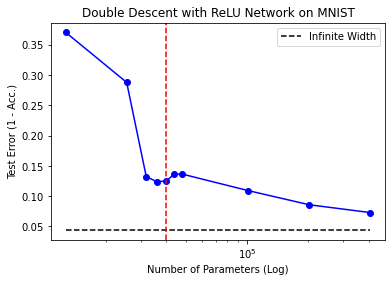

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(num_params, [1 - acc for acc in test_accs], 'bo-')
plt.plot(num_params, [1-inf_test_acc]*len(widths), 'k--', label='Infinite Width')
plt.axvline(x=40000, color='r', linestyle='--')
plt.xscale("log")
plt.xlabel("Number of Parameters (Log)")
plt.ylabel("Test Error (1 - Acc.)")
plt.title("Double Descent with ReLU Network on MNIST")
plt.legend()